# This is the script to extract Liver bounding!

In [1]:
import os
import nibabel as nib
import pandas as pd
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
#len(os.listdir('../../Data/CT_Phase/Full_Image_Liver_07075/'))

In [2]:
import os
import nibabel as nib
import numpy as np
import skimage 
import matplotlib.pyplot as plt
from tqdm import tqdm
import SimpleITK as sitk
import nibabel as nib
import math
import pandas as pd
#print(os.listdir('../../Test_Data/Test_3D/'))
class ImageLoad:
    def __init__(self,input_path):
        """
        The path should only contain images
        """
        self.input_path = input_path


        #self.images_names = os.listdir('../../Test_Data/Test_3D/')
        self.images_names = os.listdir(self.input_path)
        self.images_num = len(self.images_names)
        self.image_path = [self.input_path + name for name in self.images_names]

    def image_load(self,image_path,reader='sitk'):
        if reader == 'nib':
            return nib.load(image_path)
        elif reader == 'sitk':
            return sitk.ReadImage(image_path)
        else:
            raise ValueError("The reader should be either nib or sitk!")
        
    #def image_get_float(self):

  


class LiverBoundingBox:
    def __init__(self,liver_mask,liver_orig,out_path_box=None,file_name=None):
        """
        args:
            liver_mask: the liver mask|nib or sitk
            original_image: the original image|nib or sitk
        """
        self.liver_seg = liver_mask
        self.liver_orig = liver_orig
        self.out_path_box = out_path_box
        self.file_name = file_name
        # self.original_image = original_image
        # self.liver_mask_array = self._get_array(liver_seg)
        # self.original_arrary = self._get_array(original_image)
        # self.image_loader = image_loader
    def extract_liver(self,liver=True,no_connection=True):
        """
            get either the liver or tumor region from the mask
            args:
                mask: mask of the liver and tumor
                liver: if True return the liver region, if False return the tumor region
        """
        mask = self._get_array(self.liver_seg)
        mask = mask.astype(int)
        print(mask.shape)
        
        if liver:
            mask[mask == 2] = 1
        else:
            mask[mask == 1] = 0
            mask[mask == 2] = 1
            mask = mask.astype(int)
        if no_connection:
            return mask
        print(mask.sum())
            
        # only keep the largest connected component
        labeled = skimage.measure.label(mask, connectivity=2)

        labeled[labeled != 1] = 0
      
        mask = labeled
        print(mask.shape)

        return mask


    def tumor_bbox(self,tumor_mask, bbox_size = (36, 36,27)):
        '''
        find the center of mass of the tumor and return the bounding box
        args:
            tumor_mask: binary mask of the tumor
        returns:
            bbox: bounding box of the tumor (min_row, min_col, min_slice, max_row, max_col, max_slice = bbox)
        '''
        # find the center of mass of the tumor
        com = self.get_center_of_mass_3D(tumor_mask)
        com = np.array(com).astype(int)

        # extract bbox around the center of mass
        #should be max! should not under zero!
        min_slice = com[0] - bbox_size[0]//2
        max_slice = com[0] + bbox_size[0]//2
        min_row = com[1] - bbox_size[1]//2
        max_row = com[1] + bbox_size[1]//2
        min_col = com[2] - bbox_size[2]//2
        max_col = com[2] + bbox_size[2]//2
        print(min_row, min_col, min_slice, max_row, max_col, max_slice)
    
        return min_row, min_col, min_slice, max_row, max_col, max_slice
    

    def get_center_of_mass_3D(self,binary_image):
        # Label the connected components in the binary image
        labeled_image = skimage.measure.label(binary_image)
        
        # Compute region properties including center of mass
        props = skimage.measure.regionprops_table(labeled_image, properties=['centroid'])
        print(props)
        # Get the center of mass coordinates
        center_row = np.mean(props['centroid-0'])
        center_col = np.mean(props['centroid-1'])
        center_slice = np.mean(props['centroid-2'])
        
        # Return the center of mass coordinates as a tuple
        center_of_mass = (center_row, center_col, center_slice)
        return center_of_mass
        
    def get_liver_bounding_box(self,liver_mask):
        '''
    Function to generate bounding box for liver, from a binary liver mask
        args:
            liver_mask: binary mask of the liver

        returns:
            bbox: bounding box of the liver (min_row, min_col, min_slice, max_row, max_col, max_slice = bbox)
        '''

        # get the image_probs
        image_probs = skimage.measure.regionprops((liver_mask))

        # get the bounding box of the liver

        if len(image_probs) == 0:
            print(f'[WARNING] no liver found')
            self._recording_failing()
            return None

        ## find the adjacent box that contains the liver
        for props in image_probs:
            bbox = props.bbox
            min_slice, min_row, min_col, max_slice, max_row, max_col = bbox 
            print("this is range",min_row, min_col, min_slice, max_row, max_col, max_slice)
        return [min_row, min_col, min_slice, max_row, max_col, max_slice]

    def crop_scan(self,liver_bounding):
        """
        Crop the scan with the bounding box
        args:
            liver_bounding: the bounding box of the liver
        """
        liver_original = self._get_array(self.liver_orig)
        # get the bounding box of the liver
        min_row, min_col, min_slice, max_row, max_col, max_slice = list(map(self._check_range,liver_bounding))
        print('this is after check range',min_row, min_col, min_slice, max_row, max_col, max_slice)
        
        #crop the scan
        cropped_scan = liver_original[min_row:max_row,min_col:max_col,min_slice:max_slice]
        return cropped_scan
    
    def store_cropped_data(self,cropped_data):

        if not os.path.exists(self.out_path_box):
            os.mkdir(self.out_path_box)
            print('The path does not exist, create the path!')

        header = self.liver_orig.header
        affine = self.liver_orig.affine
        print("this is shape of cropped data",cropped_data.shape)
        cropped_image = nib.Nifti1Image(cropped_data, affine, header)


        
        nib.save(cropped_image, self.out_path_box + self.file_name)

    @staticmethod   
    def liver_detection(mask):
        if np.count_nonzero(mask) != 0:
            return True


    def _check_range(self,range_num):
        return max(0,range_num)
    
    def _get_array(self,image_file):
        return sitk.GetArrayFromImage(image_file)
    
    def _recording_failing(self):
        with open(self.out_path_box + 'failing_box.txt','a') as f:
            f.write(self.file_name + '\n')








C:\Users\098986\AppData\Local\Temp\ipykernel_26676\1951462433.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Extract tumore


In [108]:
#tumor slices with liver bounding box
liver_bounding = {'min_row': [], 'min_col': [], 'max_row': [], 'max_col': []}

In [109]:
mask_1 = sitk.ReadImage('../../Data/Mixed_HGP/Mxied_HGP_mask/CILM_CT_100330.nii.gz')
mask_1_array = sitk.GetArrayFromImage(mask_1)
cropped_out_path = '../../Data/Mixed_HGP/Miexed_HGP_Liver_Cropped/'
#load the images
image_orig_load = ImageLoad("../../Data/Mixed_HGP/Mixed_HGP_Raw/")
image_seg_load = ImageLoad("../../Data/Mixed_HGP/Mxied_HGP_mask/")
tumor_slices = []
# get the image names
for i in range(image_orig_load.images_num):
    file_name = image_orig_load.images_names[i]

    # load the image
    image_orig = image_orig_load.image_load(image_orig_load.image_path[i])
    image_seg = image_seg_load.image_load(image_seg_load.image_path[i])
    liver_bbox = LiverBoundingBox(image_seg,image_orig,cropped_out_path,file_name)
    mask_tumor_0 = liver_bbox.extract_liver(liver=True,no_connection=True)
    min_slice,max_slice = liver_tumore_info.iloc[i,:]['min_slice'],liver_tumore_info.iloc[i,:]['max_slice']
    mask_tumor_0 = mask_tumor_0[min_slice:max_slice,:,:]
    print(mask_tumor_0.shape,'shit')
    image_probs = skimage.measure.regionprops((mask_tumor_0))

    # get the bounding box of the liver
    for probs in image_probs:
        bbox = probs.bbox
        min_slice, min_row, min_col, max_slice, max_row, max_col = bbox 
        print("this is range",min_row, min_col, min_slice, max_row, max_col, max_slice)
        liver_bounding['min_row'].append(min_row)
        liver_bounding['min_col'].append(min_col)
        liver_bounding['max_row'].append(max_row)
        liver_bounding['max_col'].append(max_col)
    
        
    #
    """
    tumor_bbox = liver_bbox.tumor_bbox(mask_tumor)
    min_row, min_col, min_slice, max_row, max_col, max_slice = tumor_bbox
    with open('../../Data/Mixed_HGP/Mixed_HGP_Tumor_Bbox.txt','a') as f:
        f.write(file_name + ',' + str(min_row) + ',' + str(min_col) + ',' + str(min_slice) + ',' + str(max_row) + ',' + str(max_col) + ',' + str(max_slice) + '\n')
    """


(125, 512, 512)
(18, 512, 512) shit
this is range 128 61 0 372 320 18
(210, 512, 512)
(63, 512, 512) shit
this is range 124 62 0 380 319 63
(112, 512, 512)
(22, 512, 512) shit
this is range 88 61 0 369 330 22
(311, 512, 512)
(48, 512, 512) shit
this is range 93 48 0 385 353 48
(238, 512, 512)
(48, 512, 512) shit
this is range 143 95 0 372 318 48
(127, 512, 512)
(21, 512, 512) shit
this is range 140 101 0 335 380 21
(487, 512, 512)
(115, 512, 512) shit
this is range 56 59 0 329 314 115
(307, 512, 512)
(32, 512, 512) shit
this is range 87 38 0 347 307 32
(147, 512, 512)
(22, 512, 512) shit
this is range 148 80 0 373 325 22
(207, 512, 512)
(28, 512, 512) shit
this is range 125 91 0 341 324 28
(154, 512, 512)
(8, 512, 512) shit
this is range 136 70 0 374 203 8
(48, 512, 512)
(33, 512, 512) shit
this is range 93 46 0 372 387 33
(529, 512, 512)
(110, 512, 512) shit
this is range 130 73 0 365 345 110
(125, 512, 512)
(16, 512, 512) shit
this is range 138 43 0 387 328 16
(142, 512, 512)
(23, 51

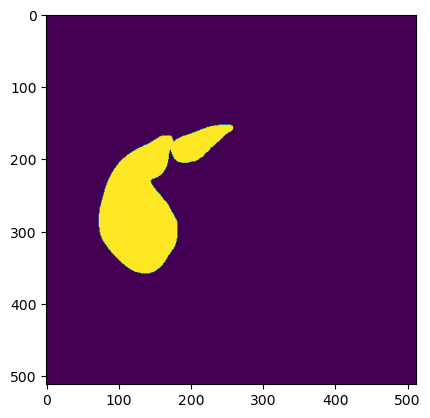

In [95]:
plt.imshow(mask_tumor_0[0,:,:])

In [110]:
#get the liver bounding box
liver_bounding_df = pd.DataFrame(liver_bounding)
liver_bounding_df['range_col'] = liver_bounding_df['max_col'] - liver_bounding_df['min_col']
liver_bounding_df['range_row'] = liver_bounding_df['max_row'] - liver_bounding_df['min_row']


In [126]:
#use liver_bounding_df replace liver_tumor_info to get the tumor bounding box
liver_tumore_info['min_row'] = liver_bounding_df['min_row']
liver_tumore_info['min_col'] = liver_bounding_df['min_col']
liver_tumore_info['max_row'] = liver_bounding_df['max_row']
liver_tumore_info['max_col'] = liver_bounding_df['max_col']

In [129]:
liver_tumore_info.to_csv('../../Data/Mixed_HGP/Mixed_HGP_tm_slice_lv_region.csv',index=False)

In [84]:
liver_tumore_info = pd.read_csv('../../Data/Mixed_HGP/True_Label/Mixed_HGP_tumor_slices_liver.csv')

In [24]:
min_slice,max_slice = liver_tumore_info.iloc[0,].min_slice,liver_tumore_info.iloc[0,].max_slice
mask_tumor_0 = mask_1_array[min_slice:max_slice,:,:]

In [37]:
mask_tumor_0[mask_tumor_0 == 2] = 1

In [42]:
#find slice with largest value
image_probs = skimage.measure.regionprops((mask_tumor_0))

# get the bounding box of the liver
for probs in image_probs:
    bbox = probs.bbox
    min_slice, min_row, min_col, max_slice, max_row, max_col = bbox 
    print("this is range",min_row, min_col, min_slice, max_row, max_col, max_slice)
    break

this is range 128 61 0 372 320 18


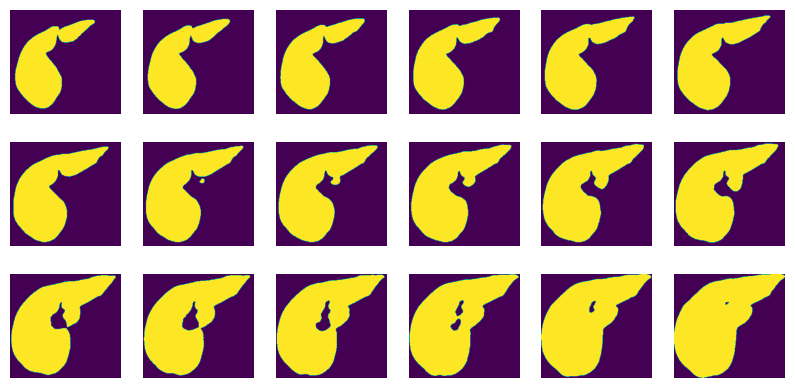

In [46]:
plt.figure(figsize=(10,10))
#show each slice
for i in range(0,mask_tumor_0.shape[0]):
    plt.subplot(6,6,i+1)
    plt.imshow(mask_tumor_0[i,min_row:max_row,min_col:max_col])
    plt.axis('off')


(0.7421875, 0.7421875, 3.0)

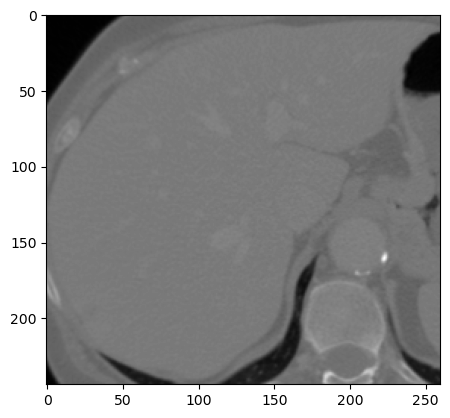

In [153]:
test = sitk.GetArrayFromImage(sitk.ReadImage('../../Data/Mixed_HGP/tm_slices_lv_region_07073/CILM_CT_550460_0000.nii.gz'))
plt.imshow(test[11,:,:],cmap='gray')
test[0,min_row:max_row,min_col:max_col].shape



sitk.ReadImage('../../Data/Mixed_HGP/tm_slices_lv_region_07073/CILM_CT_550460_0000.nii.gz').GetSpacing()

# find tumor slices by cumsum

In [55]:
def find_tumor_slices(tumor_mask):
    """
    find the tumor slices
    args:
        tumor_mask: the tumor mask
    """
    cumsum_0 = np.cumsum(mask_tumor_0,axis=0)
    cumsum_lst_0 = []
    for i in range(cumsum_0.shape[0]):
        cumsum_lst_0.append(cumsum_0[i,:,:].sum())
    gradient = np.gradient(cumsum_lst_0)
    last_zero_index = len(gradient) - 1

    #start index
    start_index = next(i for i, v in enumerate(gradient) if v > 0)
    #end index
    for i in range(len(gradient) - 1, -1,-1):
        if gradient[i] != 0:
            # 当遇到非0元素时，记录其后一个索引为最后一个0的索引
            last_zero_index = i + 1
            break
    
    return (start_index,last_zero_index)





,Experiment,min_row,min_col,min_slice,max_row,max_col,max_slice
0,CT_10033,128,61,58,372,320,76
1,CT_10043,124,62,140,380,319,203
2,CT_10104,88,61,82,369,330,104
3,CT_10203,93,48,146,385,353,194
4,CT_10702,143,95,108,372,318,156
...,...,...,...,...,...,...,...
244,CT_89320,118,38,289,345,238,343
245,CT_94131,100,43,97,370,260,113
246,CT_94912,99,35,8,350,274,31
247,CT_97575,131,99,0,334,313,6


In [69]:
tumor_slices_df = pd.DataFrame(tumor_slices)


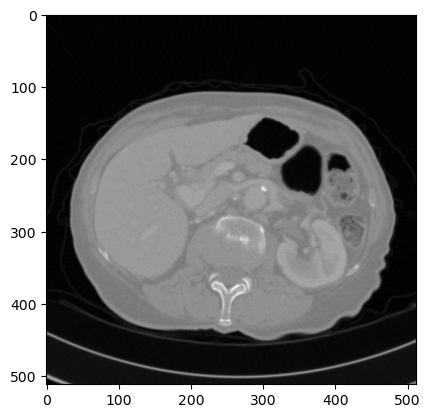

In [75]:
test_0 = sitk.GetArrayFromImage(sitk.ReadImage('../../Data/Mixed_HGP/Mixed_HGP_Raw/CILM_CT_100330_0000.nii.gz'))
plt.imshow(test_0[65,127:394,:],cmap='gray')

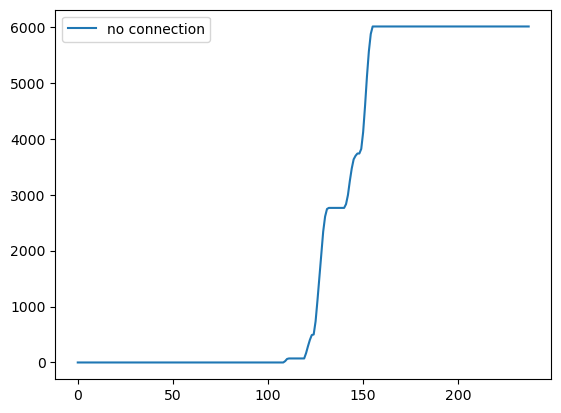

In [13]:
cumsum_0 = np.cumsum(mask_tumor_0,axis=0)
cumsum_lst_0 = []
for i in range(cumsum_0.shape[0]):
    cumsum_lst_0.append(cumsum_0[i,:,:].sum())



plt.plot(cumsum_lst_0,label='no connection')
plt.legend()


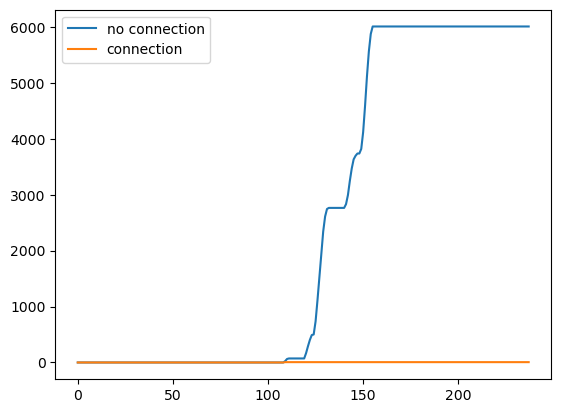

In [85]:
#cumsum from the third dimension
cumsum_0 = np.cumsum(mask_tumor_0,axis=0)
cumsum_1 = np.cumsum(mask_tumor_1,axis=0)

#Plot the cumsum AS A line
cumsum_lst_0 = []
cumsum_lst_1 = []
for i in range(cumsum_0.shape[0]):
    cumsum_lst_0.append(cumsum_0[i,:,:].sum())
    cumsum_lst_1.append(cumsum_1[i,:,:].sum())


plt.plot(cumsum_lst_0,label='no connection')
plt.plot(cumsum_lst_1,label='connection')
plt.legend()


In [160]:
cumsum_0[155,:,:].sum()

6010

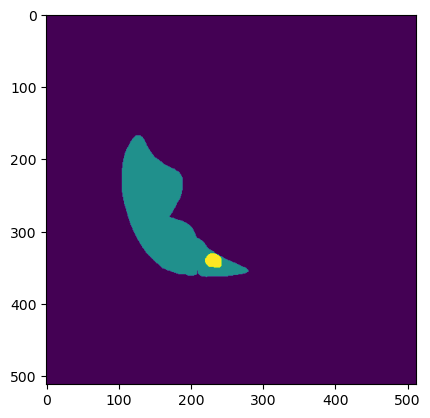

In [125]:
liver_mask = sitk.GetArrayFromImage(sitk.ReadImage('../../Data/Mixed_HGP/Mxied_HGP_mask/CILM_CT_107020.nii.gz'))
plt.imshow(liver_mask[126,:,:])

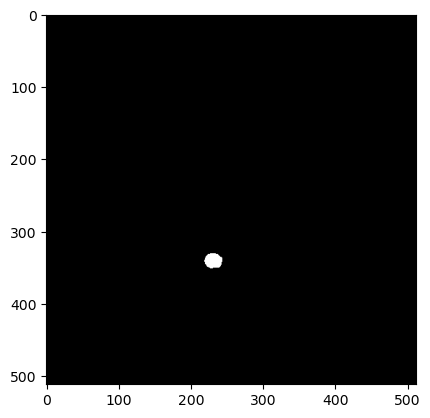

In [121]:
plt.imshow(mask_tumor_0[127,:,:],cmap='gray')
#plt.imshow(mask_tumor_1[127,:,:],cmap='gray')

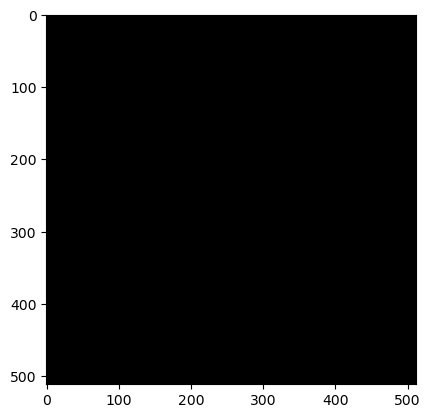

In [35]:
plt.imshow(mask_tumor[,:,:],cmap='gray')

In [36]:
liver_info_orign = pd.read_csv('../../Data/Mixed_HGP/True_Label/Mixed_HGP_tm_slice_lv_region.csv')
liver_info_orign.to_csv('../../Data/Mixed_HGP/True_Label/Mixed_HGP_tm_slice_lv_region.csv',index=False)

In [31]:
min_slice = liver_info['min_slice'] - 3
max_slice = liver_info['max_slice'] + 3
min_slice = min_slice.clip(lower=0)

max_slice = liver_info.apply(lambda x: x['max_slice'] + 3 if x['max_slice'] + 3 <= x['slice_range'] else x['slice_range'],axis=1)

liver_info['min_slice'] = min_slice
liver_info['max_slice'] = max_slice

In [33]:
liver_info.to_csv('../../Data/Mixed_HGP/True_Label/tm_slices_lv_region_+3.csv',index=False)

In [10]:
#get data range
#load the images
#image_orig_load = ImageLoad("../../Data/Mixed_HGP/Mixed_HGP_Raw/")
image_seg_load = ImageLoad("../../Data/Mixed_HGP/Mxied_HGP_mask/")

In [15]:
slices_range = {'min':[],'max':[]}
for i in range(image_seg_load.images_num):
    file_name = image_seg_load.images_names[i]

    # load the image
    #image_orig = image_orig_load.image_load(image_orig_load.image_path[i])
    print(file_name)
    image_seg = image_seg_load.image_load(image_seg_load.image_path[i])
    mask_tumor = sitk.GetArrayFromImage(image_seg)
    slices_range['max'].append(mask_tumor.shape[0])


CILM_CT_100330.nii.gz
CILM_CT_100430.nii.gz
CILM_CT_101040.nii.gz
CILM_CT_102030.nii.gz
CILM_CT_107020.nii.gz
CILM_CT_107850.nii.gz
CILM_CT_108710.nii.gz
CILM_CT_109290.nii.gz
CILM_CT_109300.nii.gz
CILM_CT_109540.nii.gz
CILM_CT_109630.nii.gz
CILM_CT_111110.nii.gz
CILM_CT_111360.nii.gz
CILM_CT_111550.nii.gz
CILM_CT_114470.nii.gz
CILM_CT_116550.nii.gz
CILM_CT_116560.nii.gz
CILM_CT_117840.nii.gz
CILM_CT_119090.nii.gz
CILM_CT_119760.nii.gz
CILM_CT_120170.nii.gz
CILM_CT_121900.nii.gz
CILM_CT_122760.nii.gz
CILM_CT_125750.nii.gz
CILM_CT_127240.nii.gz
CILM_CT_129060.nii.gz
CILM_CT_129270.nii.gz
CILM_CT_129570.nii.gz
CILM_CT_131630.nii.gz
CILM_CT_132360.nii.gz
CILM_CT_133290.nii.gz
CILM_CT_134160.nii.gz
CILM_CT_134190.nii.gz
CILM_CT_136510.nii.gz
CILM_CT_137140.nii.gz
CILM_CT_138590.nii.gz
CILM_CT_138850.nii.gz
CILM_CT_139990.nii.gz
CILM_CT_140250.nii.gz
CILM_CT_141420.nii.gz
CILM_CT_141510.nii.gz
CILM_CT_142300.nii.gz
CILM_CT_142490.nii.gz
CILM_CT_142990.nii.gz
CILM_CT_143590.nii.gz
CILM_CT_14

In [35]:
liver_info_orign['slice_range'] = slices_range_df[0]

In [ ]:
for i in range(image_orig_load.images_num):
    file_name = image_orig_load.images_names[i]
    image_orign,image_segg = image_orig_load.image_load(image_orig_load.image_path[i]),image_seg_load.image_load(image_seg_load.image_path[i])

    #finding bounding box
    liver_bbox = LiverBoundingBox(image_segg,image_orign,cropped_out_path,file_name)
    liver_mask = liver_bbox.extract_liver()
    if liver_bbox.liver_detection(liver_mask):
        liver_box_range = liver_bbox.get_liver_bounding_box(liver_mask)
        image_liver_slice[file_name] = liver_box_range
        
    else:
        liver_bbox._recording_failing()

In [276]:
range_lst

[323, 157, 43, 359, 183, 79]

In [277]:
import ast
liver_info = pd.DataFrame(pd.read_table('../../Data/Mixed_HGP/Mixed_HGP_Tumor_Bbox.txt',sep=',',header=None))
new_columns =[]

for index, row in liver_info.iterrows():
    range_lst = row[1:].tolist()
    #range_lst = ' '.join(range_lst)
    #range_lst = ast.literal_eval(range_lst)
    min_row,min_col,min_slice,max_row,max_col,max_slice = zip(range_lst)
    new_columns.append({'min_row':min_row[0],
                        'min_col':min_col[0],
                        'min_slice':min_slice[0],
                        'max_row':max_row[0],
                        'max_col':max_col[0],
                        'max_slice':max_slice[0]})

df = pd.DataFrame(new_columns)
#join the df with the original df

liver_info = pd.concat([liver_info,df],axis=1)
#DELETE 1,2,3,4,5,6column

liver_info.drop(columns=[1,2,3,4,5,6],inplace=True)

In [285]:
a = [1,2,3]
a,b,c = 

SyntaxError: invalid syntax (481099110.py, line 2)

In [288]:
liver_info.to_csv('../../Data/Mixed_HGP/True_Label/Mixed_HGP_Tumor_Bbox.csv',index=False)

In [343]:
#remove duplicates
def get_margin_size(origin_shape,range,percentage=0.1):
    """
    get the margin size of the cropped image
    args:
        origin_shape: the shape of the original image
        percentage: the percentage of the margin
        range: the range of the bounding box
    """
    min_row,min_col,min_slice,max_row,max_col,max_slice = range
    print(min_row,min_col,min_slice,max_row,max_col,max_slice,'shit')
    slice_bound,row_bound,col_bound = origin_shape.shape
    min_row = max(0,min_row - int(min_row * percentage))
    min_col = max(0,min_col - int(min_col * percentage))
    min_slice = max(0,min_slice - int(min_slice * percentage))
    max_row = min(row_bound,max_row + int(max_row * percentage))
    max_col = min(col_bound,max_col + int(max_col * percentage))
    max_slice = min(slice_bound,max_slice + int(max_slice * percentage))
    return min_row,min_col,min_slice,max_row,max_col,max_slice
        
    

In [96]:
#set the first column to Experiment

Mixed_Data = pd.read_csv('../../Data/Mixed_HGP/True_Label/scans_used_all_info.csv')
Experiment_name = Mixed_Data['Experiment'].values.tolist()

liver_info[0] = Experiment_name
#change colum name
liver_info.rename(columns={0:'Experiment'},inplace=True)


In [18]:
image_orign = nib.load('../../Data/CT_Phase/Full_Image_Liver_07075/CILM_CT_101040_0000.nii.gz')
image_orign.shape

(521, 521, 112)

# Get Liver 07073 images


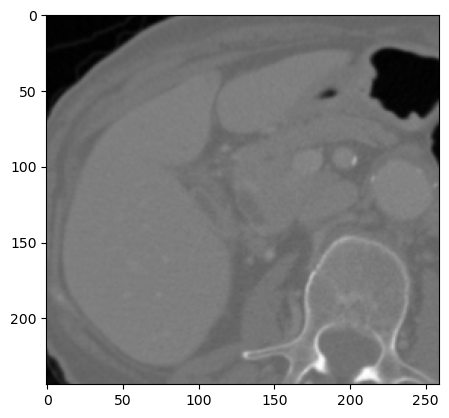

In [144]:
test_data = sitk.ReadImage('../../Data/Mixed_HGP/tm_slices_lv_region/CILM_CT_100330_0000.nii.gz')
test_data_array = sitk.GetArrayFromImage(test_data)
plt.imshow(test_data_array[0,:,:],cmap='gray')

In [44]:
liver_info

,Experiment,min_row,min_col,min_slice,max_row,max_col,max_slice,slice_range
0,CT_10033,128,61,55,372,320,79,125
1,CT_10043,124,62,137,380,319,206,210
2,CT_10104,88,61,79,369,330,107,112
3,CT_10203,93,48,143,385,353,197,311
4,CT_10702,143,95,105,372,318,159,238
...,...,...,...,...,...,...,...,...
244,CT_89320,118,38,286,345,238,346,668
245,CT_94131,100,43,94,370,260,116,204
246,CT_94912,99,35,5,350,274,34,88
247,CT_97575,131,99,0,334,313,9,64


In [46]:
import pandas as pd
liver_info = pd.read_csv('../../Data/Mixed_HGP/True_Label/tm_slices_lv_region_+3.csv')
liver_info


,Experiment,min_row,min_col,min_slice,max_row,max_col,max_slice,slice_range
0,CT_10033,128,61,55,372,320,79,125
1,CT_10043,124,62,137,380,319,206,210
2,CT_10104,88,61,79,369,330,107,112
3,CT_10203,93,48,143,385,353,197,311
4,CT_10702,143,95,105,372,318,159,238
...,...,...,...,...,...,...,...,...
244,CT_89320,118,38,286,345,238,346,668
245,CT_94131,100,43,94,370,260,116,204
246,CT_94912,99,35,5,350,274,34,88
247,CT_97575,131,99,0,334,313,9,64


In [48]:

image_folder = '../../Data/Mixed_HGP/Mixed_HGP_Raw/'


Mixed_HGP_Data = os.listdir('../../Data/Mixed_HGP/Mixed_HGP_Raw/')

Mixed_HGP_Data = [os.path.abspath(os.path.join(image_folder, f)) for f in os.listdir(image_folder)]
output_folder = '../../Data/Mixed_HGP/tm_slices_lv_region_+3/'
for index,row in liver_info.iterrows():
    img = sitk.ReadImage(Mixed_HGP_Data[index])
    img_array = sitk.GetArrayFromImage(img)
    out_name = os.path.basename(Mixed_HGP_Data[index])
    min_row,min_col,min_slice,max_row,max_col,max_slice = row.iloc[1:7]
    #get margin
    #min_row,min_col,min_slice,max_row,max_col,max_slice = get_margin_size(img_array,[min_row,min_col,min_slice,max_row,max_col,max_slice],percentage=0.2)
    print(min_row,min_col,min_slice,max_row,max_col,max_slice,'555')
    extracted_slices = img_array[min_slice:max_slice,min_row:max_row, min_col:max_col]
    output_path = os.path.join(output_folder, out_name)
    extracted_img = sitk.GetImageFromArray(extracted_slices)
    extracted_img.SetSpacing(img.GetSpacing())
    extracted_img.SetDirection(img.GetDirection())
    extracted_img.SetOrigin(img.GetOrigin())

    # 保存提取的切片
    sitk.WriteImage(extracted_img, output_path)

128 61 55 372 320 79 555
124 62 137 380 319 206 555
88 61 79 369 330 107 555
93 48 143 385 353 197 555
143 95 105 372 318 159 555
140 101 52 335 380 79 555
56 59 340 329 314 461 555
87 38 38 347 307 76 555
148 80 100 373 325 128 555
125 91 7 341 324 41 555
136 70 111 374 203 125 555
93 46 4 372 387 43 555
130 73 393 365 345 509 555
138 43 59 387 328 81 555
129 59 103 372 317 132 555
144 58 2 391 349 34 555
160 67 14 381 348 28 555
104 71 58 336 356 81 555
155 93 70 407 324 90 555
125 76 81 380 328 96 555
150 76 13 367 318 38 555
213 62 107 425 313 117 555
182 55 13 450 298 45 555
98 58 70 345 335 83 555
115 82 65 331 250 83 555
105 55 74 365 351 97 555
131 68 22 308 272 78 555
101 75 81 364 380 113 555
137 70 62 379 264 88 555
130 28 66 381 314 85 555
96 31 29 406 429 53 555
135 47 24 409 306 72 555
10 28 19 311 309 35 555
139 69 4 360 314 28 555
157 46 121 358 250 136 555
133 56 22 356 235 35 555
103 42 0 404 283 40 555
86 44 52 348 295 78 555
140 72 1 339 390 12 555
136 73 121 365 36

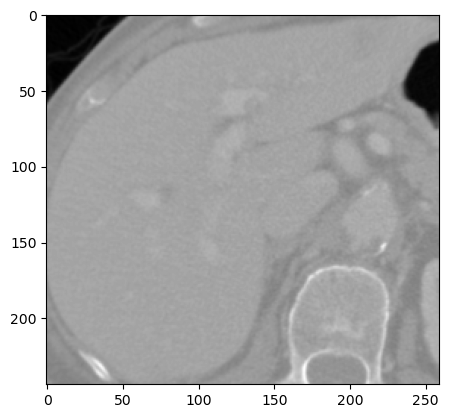

In [69]:
test_data = sitk.ReadImage('../../Data/Mixed_HGP/tm_slices_lv_region_+3/CILM_CT_100330_0000.nii.gz')
test_data_array = sitk.GetArrayFromImage(test_data)
plt.imshow(test_data_array[20,:,:],cmap='gray')

In [10]:
test_0 = sitk.ReadImage('../../Data/Mixed_HGP/Mixed_HGP_lv_with_tumor/CILM_CT_273370_0000.nii.gz')
test_0_array = sitk.GetArrayFromImage(test_0)
test_0_array.shape
test_0.GetSpacing(),test_0.GetSize()
image = test_0
out_spacing = [0.7421875, 0.7421875, 1]

In [12]:
original_spacing = test_0.GetSpacing()
new_size = [int(round(test_0.GetSize()[i] * original_spacing[i] / out_spacing[i])) for i in range(3)]
#set resample parameters
resample = sitk.ResampleImageFilter()
resample.SetOutputSpacing(out_spacing)
resample.SetSize(new_size)
resample.SetOutputDirection(test_0.GetDirection())
resample.SetOutputOrigin(test_0.GetOrigin())
resample.SetTransform(sitk.Transform())
resample.SetDefaultPixelValue(test_0.GetPixelIDValue())
resample.SetInterpolator(sitk.sitkBSpline)
out_image = resample.Execute(test_0)


: 

In [113]:
out_image.GetSize(),out_image.GetSpacing()

((245, 212, 12), (0.7421875, 0.7421875, 3.0))

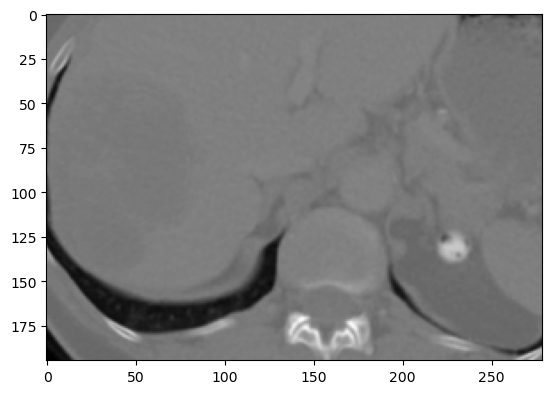

In [95]:
test_0 = sitk.ReadImage('../../Data/Mixed_HGP/Mixed_HGP_lv_with_tumor/CILM_CT_107850_0000.nii.gz')
test_0_array = sitk.GetArrayFromImage(test_0)

plt.imshow(test_0_array[12,:,:],cmap='gray')

# Windowing

In [3]:
def apply_window_to_volume(batched_volumes, window_center, window_width):
    """
    Apply windowing to a batch of 3D volumes.
    :param batched_volumes: The input batch of 3D volumes.
    :param window_center: The center of the window (window level).
    :param window_width: The width of the window.
    :return: Windowed batch of 3D volumes.
    """
    lower_bound = window_center - window_width / 2
    upper_bound = window_center + window_width / 2
    windowed_batched_volumes = np.clip(batched_volumes, lower_bound, upper_bound)
    return windowed_batched_volumes

# image = sitk.ReadImage("../../Data/Mixed_HGP/Mixed_HGP_Only_Liver_07073/")
# image = sitk.GetArrayFromImage(image)
def apply_HU_values(batched_volumes,min_HU,max_HU):
    """
    Apply windowing to a batch of 3D volumes.
    :param batched_volumes: The input batch of 3D volumes.
    :param window_center: The center of the window (window level).
    :param window_width: The width of the window.
    :return: Windowed batch of 3D volumes.
    """
    lower_bound = min_HU
    upper_bound = max_HU
    windowed_batched_volumes = np.clip(batched_volumes, lower_bound, upper_bound)
    return windowed_batched_volumes
# windowed_image = apply_window_to_volume(image, 50, 400)

# plt.imshow(windowed_image[20,:,:], cmap='gray')

In [357]:
orign = sitk.ReadImage("../../Data/Mixed_HGP/tm_slices_lv_region_+3_07073/")
print(orign.GetSpacing())
orign = sitk.GetArrayFromImage(orign)

resamp = sitk.ReadImage("../../Data/Mixed_HGP/Mixed_HGP_Only_Tumor_07073/CILM_CT_100330_0000.nii.gz")
print(resamp.GetSize())
resamp = sitk.GetArrayFromImage(resamp)
resamp.shape

(0.58984375, 0.58984375, 2.0)
(74, 136, 39)


(39, 136, 74)

In [6]:
#windows the image
windowed_imgs = os.listdir('../../Data/Mixed_HGP/tm_slices_lv_region_+3_07073/')
windowed_imgs = [os.path.abspath(os.path.join('../../Data/Mixed_HGP/tm_slices_lv_region_+3_07073/', f)) for f in os.listdir('../../Data/Mixed_HGP/tm_slices_lv_region_+3_07073/')]

output_folder = '../../Data/Mixed_HGP/tm_slices_lv_region_+3_07073_clipped/'
#os.mkdir(output_folder)
#os.mkdir(output_folder )
#os.mkdir(output_folder)
#os.mkdir(output_folder)
for index,img in enumerate(windowed_imgs):
    image = sitk.ReadImage(img)
    image_array = sitk.GetArrayFromImage(image)
    out_name = os.path.basename(img)
    output_path = os.path.join(output_folder, out_name)

    #windowed_image = apply_window_to_volume(image_array, 50, 400)
    windowed_image = apply_HU_values(image_array,-100,400)
    
    
    windowed_image = sitk.GetImageFromArray(windowed_image)
    windowed_image.SetSpacing(image.GetSpacing())
    windowed_image.SetDirection(image.GetDirection())
    windowed_image.SetOrigin(image.GetOrigin())
    sitk.WriteImage(windowed_image, output_path)
    
    

(38, 203, 180)

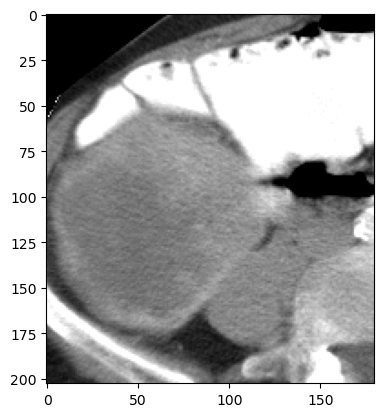

In [72]:
windowed_imgs = sitk.ReadImage('../../Data/Mixed_HGP/tm_slices_lv_region_+3_07073_windowed/CILM_CT_177130_0000.nii.gz')
windowed_imgs = sitk.GetArrayFromImage(windowed_imgs)
plt.imshow(windowed_imgs[15,:,:], cmap='gray')
windowed_imgs.shape

In [74]:
windowed_imgs = sitk.ReadImage('../../Data/Mixed_HGP/tm_slices_lv_region_+3_07073_clipped/CILM_CT_177130_0000.nii.gz')
windowed_imgs = sitk.GetArrayFromImage(windowed_imgs)
windowed_imgs.shape
#plt.imshow(windowed_imgs[21,:,:], cmap='gray')

(38, 203, 180)

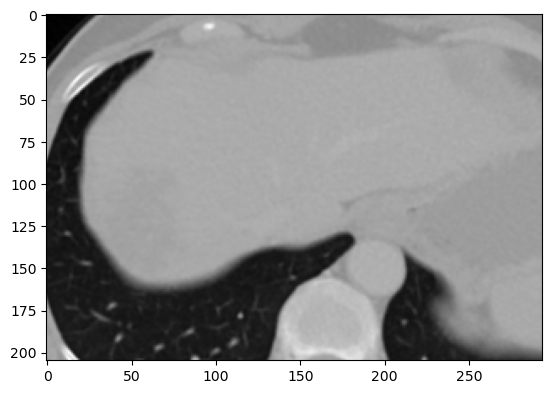

In [159]:
windowed_imgs = sitk.ReadImage('../../Data/Mixed_HGP/tm_slices_lv_region_07073//CILM_CT_107850_0000.nii.gz')
windowed_imgs = sitk.GetArrayFromImage(windowed_imgs)
plt.imshow(windowed_imgs[30,:,:], cmap='gray')

In [ ]:

   


    print('saved!')

In [ ]:
    sitk.WriteImage(windowed_image, output_folder + out_name)
    print('saved!')

In [6]:
import SimpleITK as sitk
import pandas as pd
import math

def adjust_bbox(df, margin):
    """
    Adjust the bounding box dimensions by a specified margin and convert to integers.

    :param df: DataFrame with the bounding box information.
    :param margin: The margin to adjust by, as a percentage.
    """
    df['min_row'] = (df['min_row'] - (df['max_row'] - df['min_row']) * margin).clip(lower=0).apply(math.floor)
    df['max_row'] = (df['max_row'] + (df['max_row'] - df['min_row']) * margin).apply(math.ceil)
    df['min_col'] = (df['min_col'] - (df['max_col'] - df['min_col']) * margin).clip(lower=0).apply(math.floor)
    df['max_col'] = (df['max_col'] + (df['max_col'] - df['min_col']) * margin).apply(math.ceil)

    return df


NameError: name 'liver_info' is not defined

In [50]:

liver_info = pd.read_csv('../../Data/CT_Phase/Liver_slice_info.csv')
def crop_and_save_image(row, file_path, output_folder):
    """
    Crop the image based on the bounding box and save the cropped image.

    :param row: Row of the DataFrame with bounding box and file information.
    :param file_path: Path to the folder containing the images.
    :param output_folder: Folder where the cropped images will be saved.
    """
   # 读取图像
    image = sitk.ReadImage(file_path + row[0])
    image_array = sitk.GetArrayFromImage(image)

    # 获取图像尺寸
    size_x, size_y, size_z = image.GetSize()
    print("size_z",size_z)

    # 计算裁剪区域
    # start_col = max(row['min_col'], 0)
    # start_row = max(row['min_row'], 0)
    # start_slice = max(row['min_slice'], 0)

    # end_col = size_x
    # end_row = size_y
    # end_slice = min(row['max_slice'], size_z)

    start_col = row['min_col']
    start_row = row['min_row']
    start_slice = row['min_slice']

    end_col = row['max_col']
    end_row = row['max_row']
    end_slice = row['max_slice']

    


    size = [end_col - start_col, end_row - start_row, end_slice - start_slice]
    print(size)

    # 裁剪图像
    cropped_image = image_array[start_slice:end_slice, start_row:end_row, start_col:end_col]
    cropped_image = sitk.GetImageFromArray(cropped_image)    

    #print img name

    print(row[0])

    # 保存图像
    sitk.WriteImage(cropped_image, output_folder + row[0])
    print(666,[start_col, start_row, start_slice],size)
    
    print(cropped_image.GetSize())




# 调整边界框并取整
adjusted_df = adjust_bbox(liver_info, margin=0)




In [28]:
a = sitk.GetArrayFromImage(sitk.ReadImage('../../Data/CT_Phase/Full_Image_Liver_Crop_tem/CILM_CT_101040_0000.nii.gz'))

RuntimeError: Exception thrown in SimpleITK ImageFileReader_Execute: D:\a\1\sitk\Code\IO\src\sitkImageReaderBase.cxx:97:
sitk::ERROR: The file "../../Data/CT_Phase/Full_Image_Liver_Crop_tem/CILM_CT_101040_0000.nii.gz" does not exist.

In [51]:

# 遍历DataFrame以裁剪和保存图像
for index, row in liver_info.iterrows():
    crop_and_save_image(row, f'../../Data/CT_Phase/Full_Image_Liver/', '../../Data/CT_Phase/Full_Image_Liver_Crop_tem/')
    
        



C:\Users\098986\AppData\Local\Temp\ipykernel_25224\2751954096.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image = sitk.ReadImage(file_path + row[0])
C:\Users\098986\AppData\Local\Temp\ipykernel_25224\2751954096.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(row[0])
C:\Users\098986\AppData\Local\Temp\ipykernel_25224\2751954096.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sitk.WriteImage(cropped_image, out

size_z 112
[281, 269, 39]
CILM_CT_101040_0000.nii.gz
666 [143, 61, 72] [281, 269, 39]
(281, 269, 39)
size_z 56
[270, 305, 35]
CILM_CT_102030_0000.nii.gz
666 [146, 43, 19] [270, 305, 35]
(270, 305, 35)
size_z 37
[207, 201, 28]
CILM_CT_104550_0000.nii.gz
666 [176, 92, 7] [207, 201, 28]
(207, 201, 28)
size_z 61
[218, 322, 56]
CILM_CT_104551_0000.nii.gz
666 [169, 94, 2] [218, 322, 56]
(218, 322, 56)
size_z 79
[221, 346, 35]
CILM_CT_104552_0000.nii.gz
666 [166, 87, 42] [221, 346, 35]
(221, 346, 35)
size_z 59
[190, 284, 12]
CILM_CT_107850_0000.nii.gz
666 [178, 103, 0] [190, 284, 12]
(190, 284, 12)
size_z 127
[195, 279, 31]
CILM_CT_107851_0000.nii.gz
666 [177, 101, 48] [195, 279, 31]
(195, 279, 31)
size_z 48
[279, 341, 38]
CILM_CT_111110_0000.nii.gz
666 [140, 46, 5] [279, 341, 38]
(279, 341, 38)
size_z 42
[257, 346, 36]
CILM_CT_111111_0000.nii.gz
666 [143, 30, 0] [257, 346, 36]
(257, 346, 36)
size_z 48
[238, 347, 38]
CILM_CT_111112_0000.nii.gz
666 [176, 40, 5] [238, 347, 38]
(238, 347, 38)
si

In [38]:
import matplotlib.pyplot as plt
image_path = '../../Data/CT_Phase/Full_Image_Liver_07075/CILM_CT_176841_0000.nii.gz'
image_name = 'CILM_CT_176841_0000.nii.gz'
cropped_out_path = '../../Data/CT_Phase/Full_image_Liver_slice_07075/'

os.makedirs(cropped_out_path,exist_ok=True)
save_liver_slice(image_path,image_name,cropped_out_path,slice_margin=0.5)



(539, 539, 85) 666
min and max slice 333 528
fucking max slice 528
fucking after 85
166 85
(539, 539, 0)
saved!


In [ ]:

#save all slice that includes liver,full image not resample!
for i in tqdm(range(image_orig_load.images_num)):
    file_name = image_orig_load.images_names[i]
    image_path = image_orig_load.image_path[i]
    save_liver_slice(image_path,file_name,cropped_out_path,slice_margin=0.5)



In [34]:
image_orig_load = ImageLoad("../../Data/CT_Phase/Full_Image_Liver_07075/")
os.mkdir('../../Data/CT_Phase/Full_image_Liver_slice_07075/')
cropped_out_path = '../../Data/CT_Phase/Full_Image_Liver_slice_07075/'

FileExistsError: [WinError 183] Cannot create a file when that file already exists: '../../Data/CT_Phase/Full_image_Liver_slice_07075/'

In [ ]:
#resample slice includes liver
for i in tqdm(range(image_orig_load.images_num)):
    file_name = image_orig_load.images_names[i]
    image_path = image_orig_load.image_path[i]
    save_liver_slice(image_path,file_name,cropped_out_path,slice_margin=0.5)

# Flip

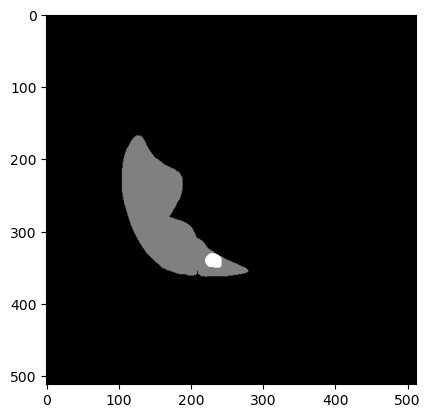

In [127]:
import matplotlib.pyplot as plt
import SimpleITK as sitk
img = sitk.ReadImage('../../Data/Mixed_HGP/Mxied_HGP_mask/CILM_CT_107020.nii.gz')
img_array = sitk.GetArrayFromImage(img)


plt.imshow(img_array[126,:,:],cmap='gray')

In [130]:
flip_img.GetSpacing()

(0.87890625, 0.87890625, 3.0)

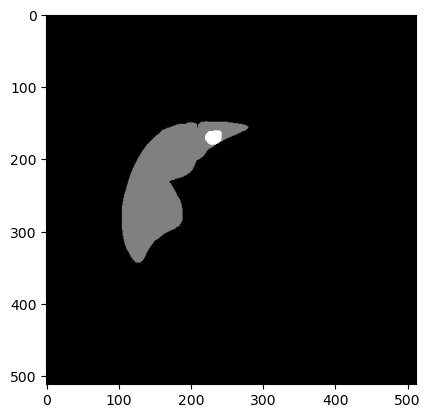

In [129]:
img_arrary = sitk.GetArrayFromImage(img)

flip_img = sitk.Flip(img,[False,True,False])


#save flipped image

filp_array = sitk.GetArrayFromImage(flip_img)
plt.imshow(filp_array[126,:,:],cmap='gray')


In [131]:
image_orig_load = ImageLoad("../../Data/Mixed_HGP/Mxied_HGP_mask/")
cropped_out_path = '../../Data/Mixed_HGP/Mxied_HGP_mask/'


for i in tqdm(range(image_orig_load.images_num)):
    file_name = image_orig_load.images_names[i]
    image_path = image_orig_load.image_path[i]
    img_sitk = sitk.ReadImage(image_path)
    flip_img = sitk.Flip(img_sitk,[False,True,False])
    sitk.WriteImage(flip_img,cropped_out_path + file_name)

100%|██████████| 249/249 [00:18<00:00, 13.23it/s]


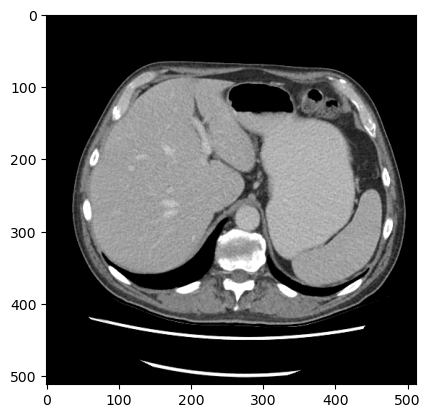